In [4]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [10]:
def calculate_parabolic_sar(high, low, initial_af=0.02, max_af=0.2):
    # Initialize variables
    length = len(high)
    psar = [0.0] * length
    bullish = True  # Start with a bullish trend
    af = initial_af
    ep = high[0]  # Extreme Point
    
    # Set initial PSAR
    psar[0] = low[0]

    for i in range(1, length):
        # Calculate PSAR for the current period
        if bullish:
            psar[i] = psar[i-1] + af * (ep - psar[i-1])
        else:
            psar[i] = psar[i-1] - af * (abs(ep - psar[i-1]))

        # Check for trend reversal
        reverse = False
        if bullish:
            if low[i] < psar[i]:
                bullish = False
                reverse = True
                psar[i] = ep
                ep = low[i]
                af = initial_af
        else:
            if high[i] > psar[i]:
                bullish = True
                reverse = True
                psar[i] = ep
                ep = high[i]
                af = initial_af

        # If no reversal, update EP and AF
        if not reverse:
            if bullish:
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + initial_af, max_af)
            else:
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + initial_af, max_af)
                    
        # Ensure PSAR is not beyond the prior two periods' low/high
        if bullish:
            psar[i] = min(psar[i], low[i-1], low[i] if i > 0 else low[i])
        else:
            psar[i] = max(psar[i], high[i-1], high[i] if i > 0 else high[i])


    return pd.Series(psar, index=high.index)



In [11]:
# --- 1. Data Fetching ---
# Fetch historical data for NVIDIA (NVDA) for the last two years
nvda_data = yf.download('NVDA', start='2025-01-01', end='2025-07-31')


/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_54172/2057089000.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda_data = yf.download('NVDA', start='2025-01-01', end='2025-07-31')
[*********************100%***********************]  1 of 1 completed


In [12]:
    # --- 1. Handle possible MultiIndex on columns ---
    # yfinance returns a MultiIndex (field, ticker) if group_by="ticker" is implicit.
if isinstance(nvda_data.columns, pd.MultiIndex):
        # Option A – drop the outer level (works when only one ticker):
    nvda_data = nvda_data.droplevel(1, axis=1)
        # If you ever request multiple tickers, use .xs() or reshape differently.



nvda_data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,138.287674,138.857589,134.608275,135.978049,198247200
2025-01-03,144.446686,144.876609,139.707445,139.987399,229322500
2025-01-06,149.405869,152.135439,147.796143,148.566008,265377400
2025-01-07,140.117371,153.105279,139.987387,153.005289,351782200
2025-01-08,140.087387,143.926764,137.537796,142.556990,227349900


In [13]:

# --- 2. Parabolic SAR Calculation ---
# Calculate SAR and add it as a new column
nvda_data['PSAR'] = calculate_parabolic_sar(nvda_data['High'], nvda_data['Low'])


/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_54172/655919659.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ep = high[0]  # Extreme Point
/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_54172/655919659.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  psar[0] = low[0]
/var/folders/3n/c2cyvjmd52585bcd83mjw9dw0000gp/T/ipykernel_54172/655919659.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if low

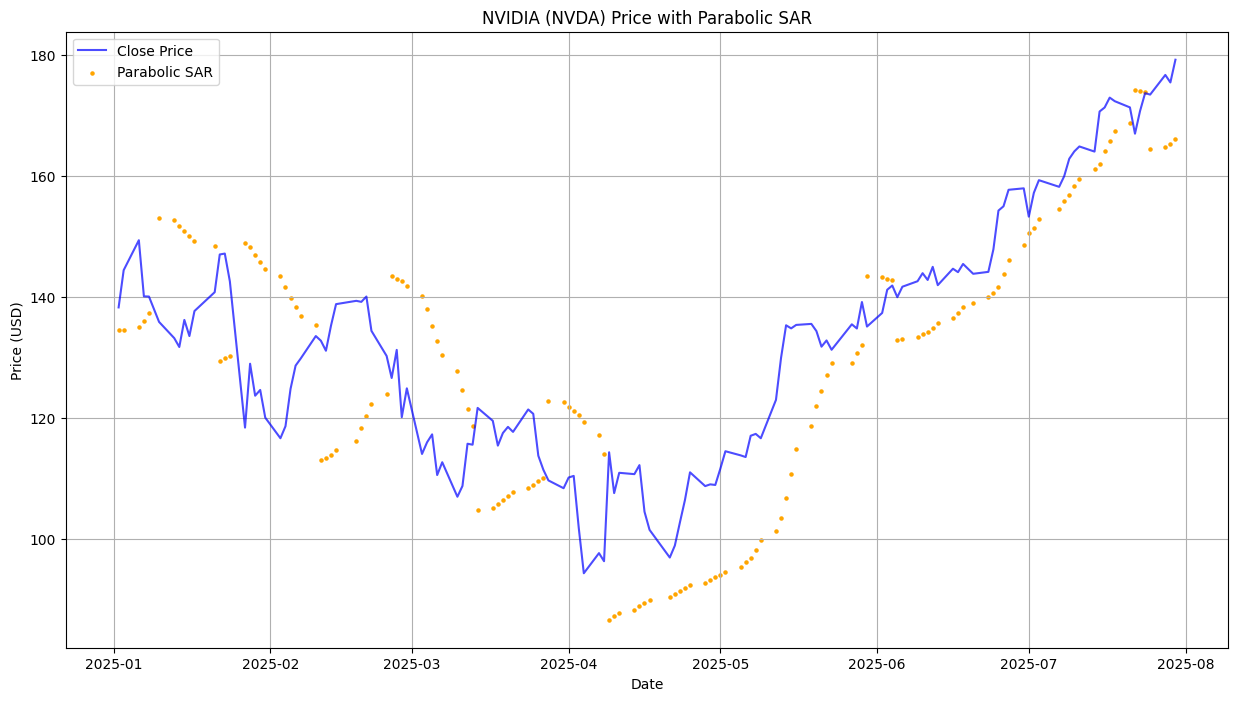

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2025-07-24  173.740005  173.830002  171.300003  172.440002  128984600   
2025-07-25  173.500000  174.720001  172.960007  173.610001  122316800   
2025-07-28  176.750000  177.000000  173.970001  174.020004  140023500   
2025-07-29  175.509995  179.380005  175.020004  177.960007  154077500   
2025-07-30  179.270004  179.889999  176.039993  176.509995  174312200   

Price             PSAR  
Date                    
2025-07-24  173.867068  
2025-07-25  164.580002  
2025-07-28  164.782802  
2025-07-29  165.271490  
2025-07-30  166.118001  


In [14]:
# --- 3. Visualization ---
# Create a figure and a single subplot
plt.figure(figsize=(15, 8))

# Plot the closing price
plt.plot(nvda_data.index, nvda_data['Close'], label='Close Price', color='blue', alpha=0.7)

# Plot the Parabolic SAR using a scatter plot for the dots
plt.scatter(nvda_data.index, nvda_data['PSAR'], label='Parabolic SAR', color='orange', s=5) # s is the marker size

plt.title('NVIDIA (NVDA) Price with Parabolic SAR')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# Display the last few rows of the DataFrame
print(nvda_data.tail())
